<a href="https://colab.research.google.com/github/nathamon24/image-processing/blob/main/Activity/Activity%239/Lab9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import glob
from keras.preprocessing import image
from sklearn.cluster import KMeans
from skimage.feature import hog
from skimage import exposure
from skimage import measure
from tensorflow.keras.preprocessing.image import load_img, img_to_array
             

**9.1.1 VIEW HOG FEATURE OF IMAGE** 

<Figure size 432x288 with 0 Axes>

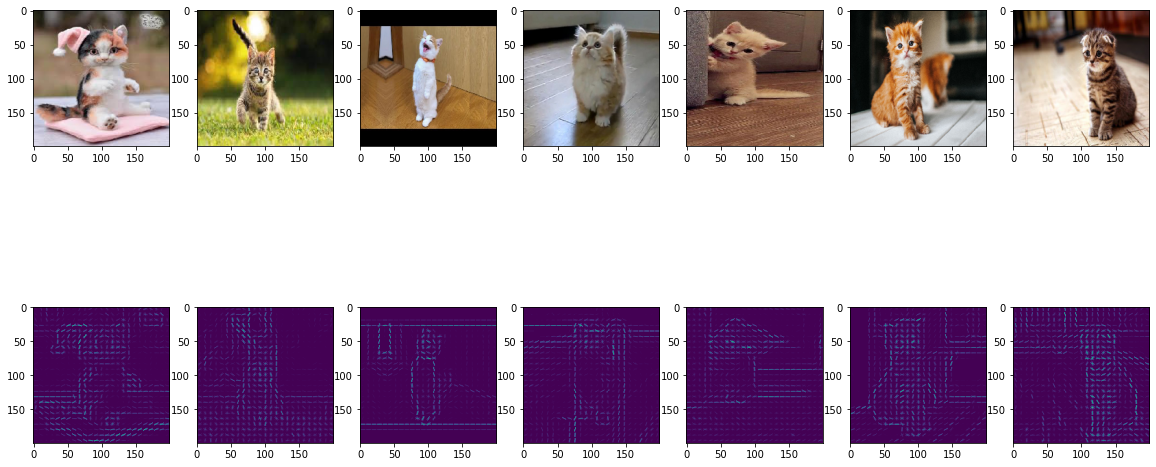

In [2]:
#Load main images in dataset
# ลองอย่างน้อย 4 รูป เพื่อหาพารามิเตอร์ที่ดีที่สุด เช่น block_size (ขนาดบล็อก), stride (ระยะขยับ sliding window)
filenames= glob.glob(f"/content/drive/MyDrive/Work/CE/Colab/Animals/Cats/*.jpg")
height,width,ch = 200,200,3
all_imgs = []
all_oriented_imgs = []
for i in range(len(filenames)):
  img = load_img(filenames[i], grayscale=False, color_mode='rgb', target_size = 
                 (height,width,ch), interpolation="nearest")
  img = img_to_array(img)
  img = img/255
  # Create Image Feature
  # Bluring image to reduce noise
  blur = cv2.GaussianBlur(img,(5,5),0) #Gaussian Filtering
  # Calculate HoG of image
  fd, hog_image = hog(blur, orientations=9, pixels_per_cell=(8, 8),
  cells_per_block=(2, 2), visualize=True, multichannel=True)
  all_imgs.append(img)
  all_oriented_imgs.append(hog_image)

#display noisy images
plt.figure()
f1, axarr1 = plt.subplots(2,len(all_imgs),figsize=(20,10)) 
for i in range(len(all_imgs)):
  axarr1[0][i].imshow((all_imgs[i]* 255).astype(np.uint8))
  axarr1[1][i].imshow((all_oriented_imgs[i]* 255).astype(np.uint8))


9.1.2 PREPARE HOG FEATURE OF SUBIMAGES

In [3]:
#Define block size for subimage
Block_size = [(40, 20),(60, 30),(60, 40)] # ลองอย่างน้อย 3 ค่า เช่น (40,20), (40, 30), (60, 20), (60,30), (60,40)
# Define stride (ระยะขยับ pixel เพื่อทำ sliding window เพื่อคำนวณ HoG)
tx, ty = 5,5
stride = (tx, ty)

# Define Sliding window position of row, column (Top left position)
posRow, posCol = [], []
for i in range(3):
  posRow.append(np.arange(0, height - Block_size[i][0]+1, stride[0]))
  # posCol.append(np.arange(0,width - tile_size[1]+1, stride[1]))
  posCol.append(np.arange(0,width - Block_size[i][1]+1, stride[1]))

# Create subimage feature
# Calculate HoG of each subimage in Sliding window
hogfeatures = []
for index in range(3):
  temp = []
  for i in range(len(posRow[index])):
    for j in range(len(posCol[index])):
      startH = posRow[index][ i ]
      endH = posRow[index][i] + Block_size[index][0]
      startW = posCol[index][ j ]
      # endW = posCol[index][j] + tile_size[1]
      endW = posCol[index][j] + Block_size[index][1]
      # subImg = img[ startH:endH , startW:endW ,:]
      subImg = all_imgs[index][startH:endH , startW:endW]

      blur = cv2.GaussianBlur(subImg,(5,5),0) #Gaussian Filtering
      fd, hog_image = hog(blur, orientations=9, pixels_per_cell=(4, 4),
                              cells_per_block=(2, 2), visualize=True, multichannel=True)
      temp.append(fd)
  hogfeatures.append(temp)

9.2.1 K-MEAN CLUSTERING

In [4]:
# Clean feature if NA
# fillna(0)

# K-mean Clustering
N = 2
clusters = []
kmeans = KMeans(n_clusters=N, random_state=0)
for i in range(3):
  clusters.append(kmeans.fit_predict(hogfeatures[i]))

9.2.2 REGION OF INTEREST (ROI)

<Figure size 432x288 with 0 Axes>

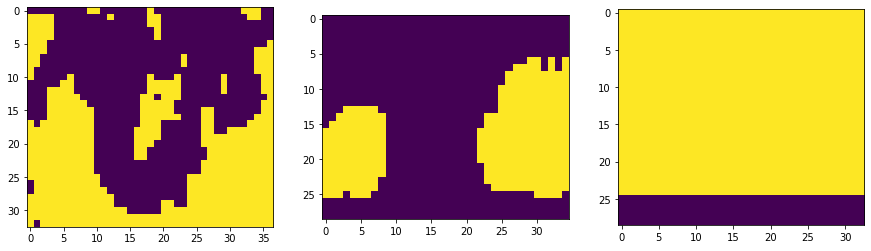

In [5]:
plt.figure()
f2, axarr2 = plt.subplots(1,3,figsize=(15,45)) 
  
# Reshape clusterID result to Grid
cluster_array = []
for i in range(3):
  cluster_array.append(clusters[i].reshape(len(posRow[i]),len(posCol[i])))

  # View cluster_array Result
  # print(cluster_array[i])
  axarr2[i].imshow(cluster_array[i])

**9.3 ROI: Region of Interest Drawing ROI bounding box**

9.3.1 K-MEAN CLUSTERING

<Figure size 432x288 with 0 Axes>

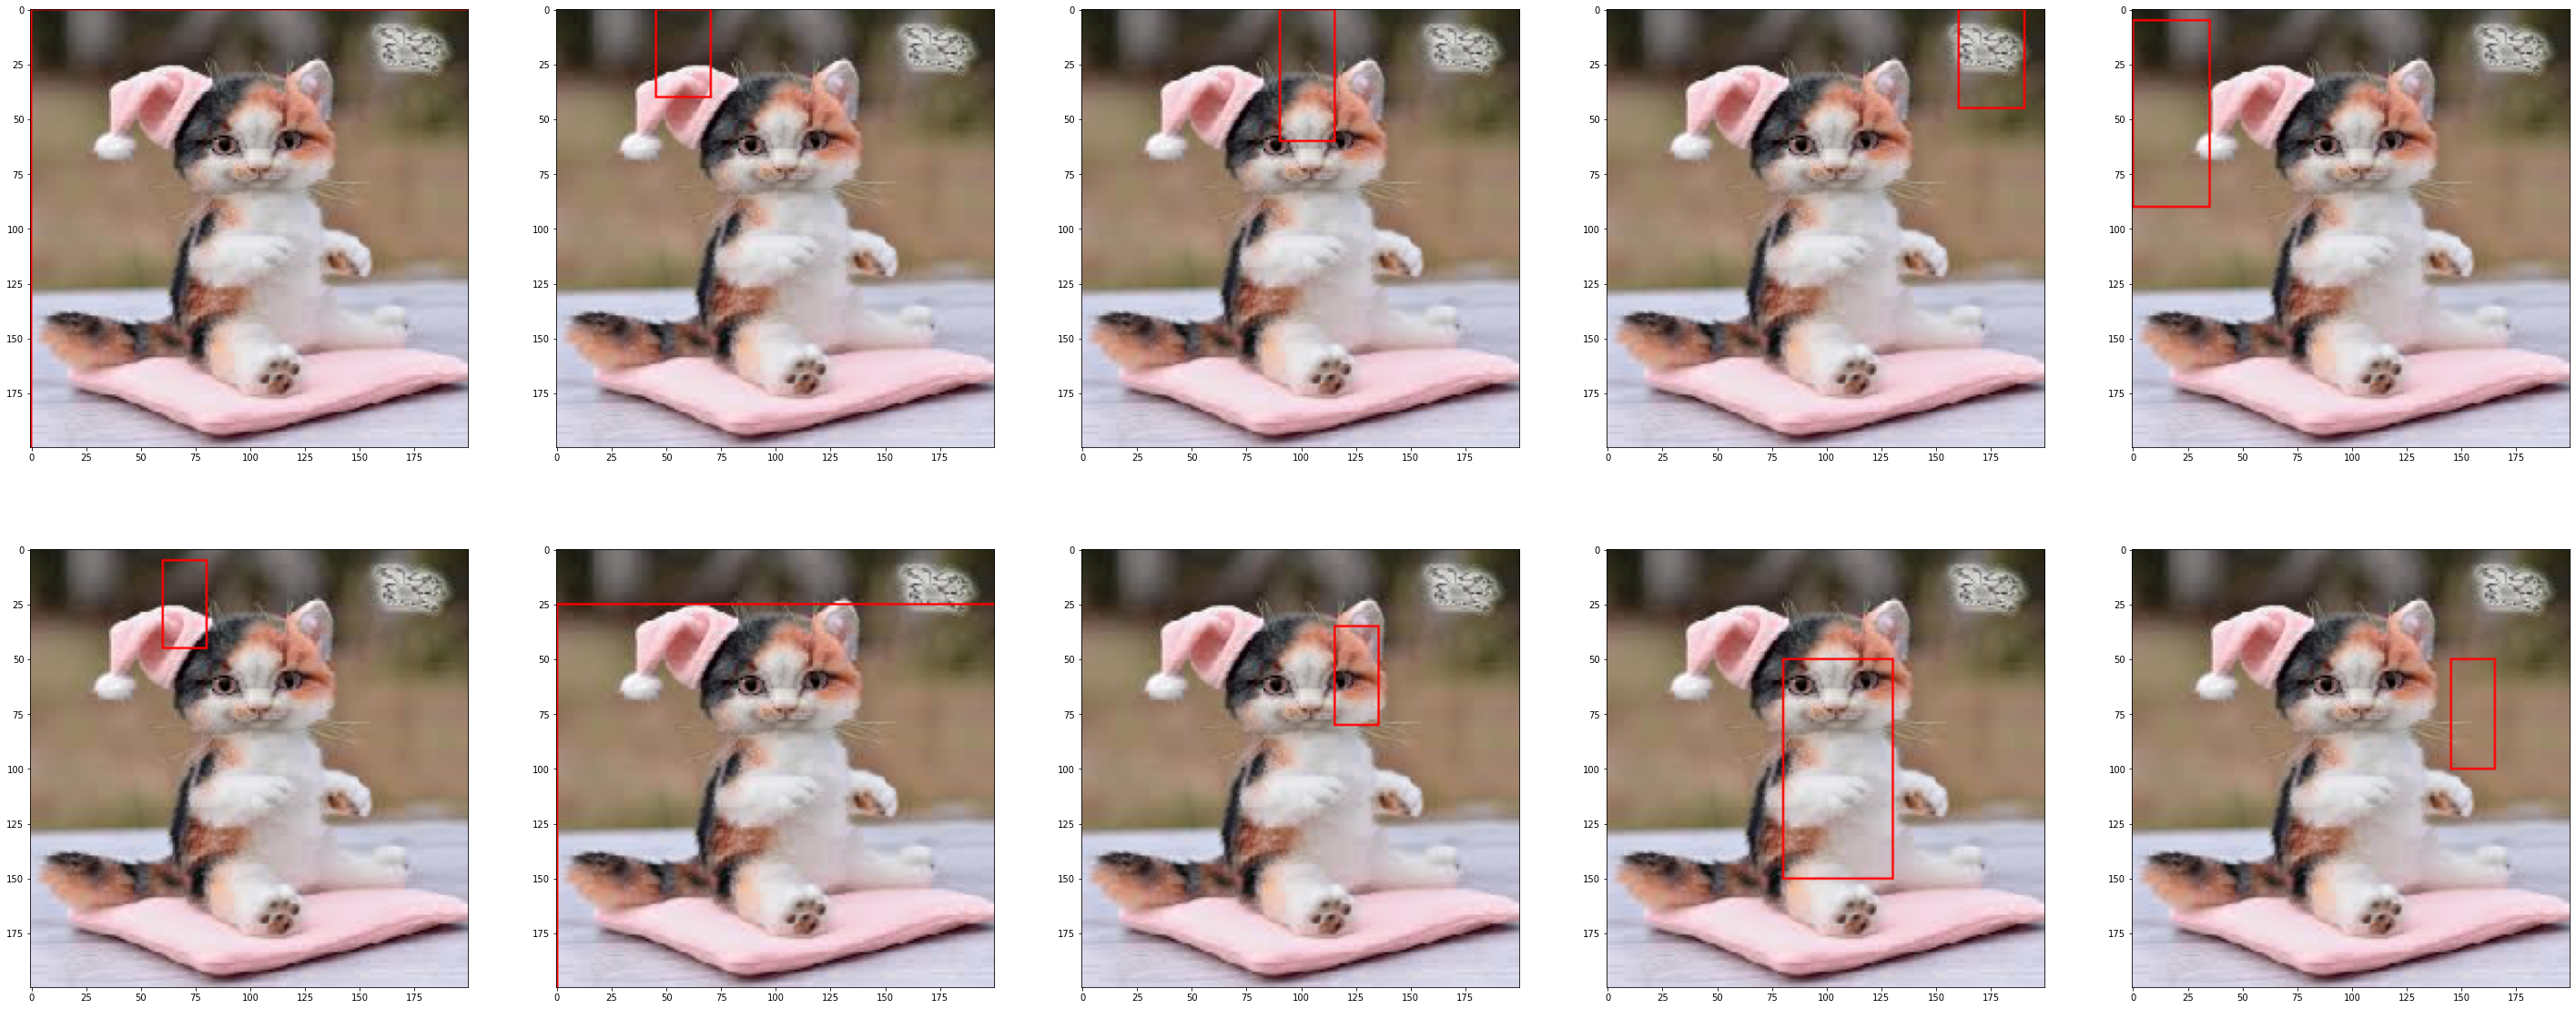

<Figure size 432x288 with 0 Axes>

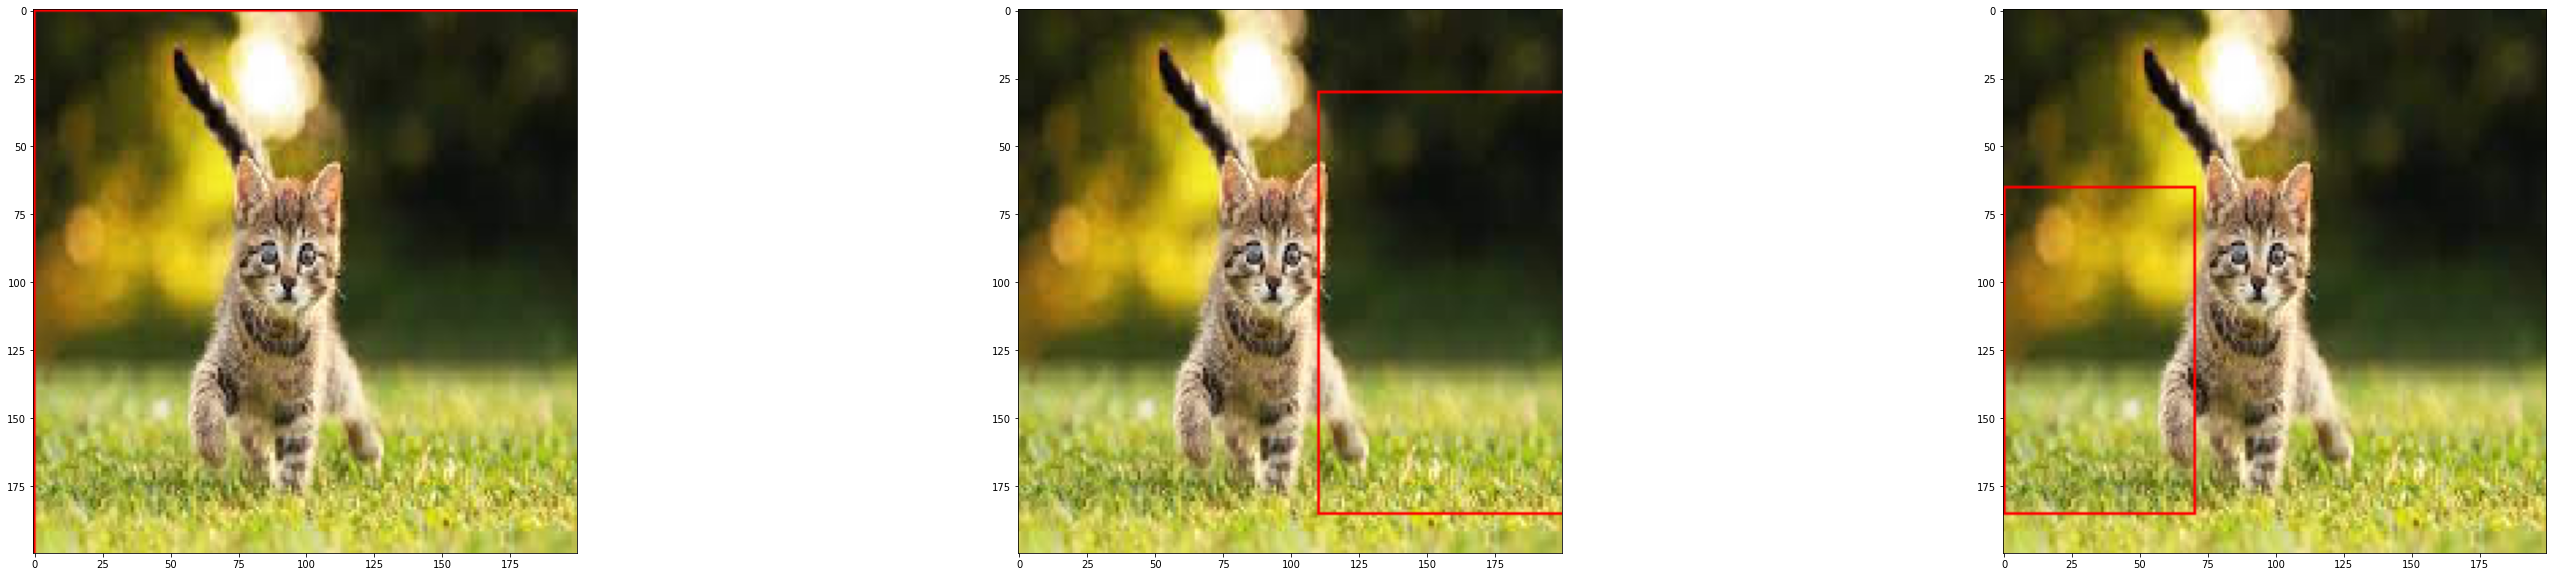

<Figure size 432x288 with 0 Axes>

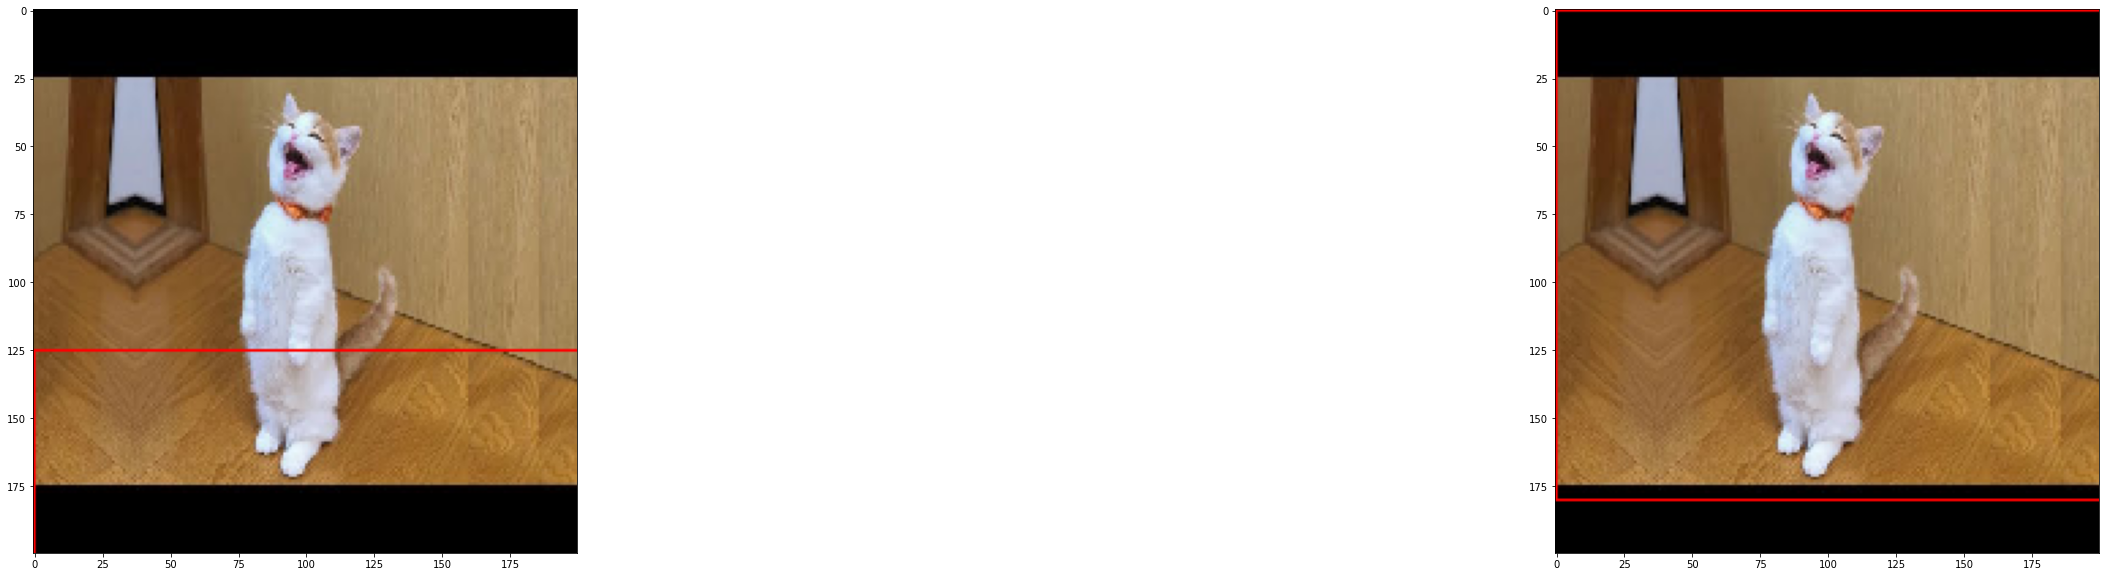

In [33]:
for index in range(3):
  # ReAssign Label in case of multiple ROIs with the same clusterID
  all_labels = measure.label(cluster_array[index])
  # Define bounding box parameter
  color = (255,0,0)
  thickness = 1

  # ROI bounding box
  nClass = np.unique(all_labels)
  plt.figure()
  if len(nClass)>=5: nRow,nCol,row,col = len(nClass)//5,5,0,0
  else : nRow,nCol = 1,len(nClass)
  f3, axarr3 = plt.subplots(nRow,nCol,figsize=(50,10*nRow)) 
  
  for i in nClass:
    #calculate from grid to actual position
    objPos = np.argwhere(all_labels== i)
    startBlockH = objPos[:,0].min()
    endBlockH = objPos[:,0].max()
    startBlockW = objPos[:,1].min()
    endBlockW = objPos[:,1].max()
    startF = (posCol[index][startBlockW], posRow[index][startBlockH])
    endF =(posCol[index][endBlockW]+Block_size[index][1], posRow[index][endBlockH]+Block_size[index][0])
          
    # draw regtangle boundary
    ROI_bounding_img = cv2.rectangle((all_imgs[index]*255).astype(np.uint8), startF, endF, color, thickness)
    if nRow == 1: axarr3[i].imshow(ROI_bounding_img)
    else : 
      if( i>0 and i%5 == 0): row,col = row+1,0
      axarr3[row][col].imshow(ROI_bounding_img)
      col+=1

    
